In [1]:
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt

In [2]:
yoloFiles = '/home/aman/Documents/Project/DepthCal/Code/Tiny Yolo Files/'

In [3]:
net = cv2.dnn.readNet(yoloFiles + 'yolov3-tiny.weights',yoloFiles + 'yolov3-tiny.cfg')
classes = []
with open(yoloFiles + 'coco.names','r') as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames() #convo layers
output_layers = [layer_names[i[0]-1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0,255,size = (len(classes),3))

In [4]:
path = "/home/aman/Documents/Project/DepthCal/Code/Data/"
right = path + 'right/'
left = path + "left/"

In [5]:
def objectDetection(img):
    li = []
    w = 0
    height,width,channels = img.shape
    blob = cv2.dnn.blobFromImage(img,.00392,(416,416), (0,0,0),True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence>.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)

                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x0 = int(center_x - (w / 2))
                x1 = x0 + w

                y0 = int(center_y - (h / 2))
                y1 = y0 + h
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
                if x0 < 0:
                    x0 = 0
                if x1 > width:
                    x1 = width
                if y0 < 0:
                    y0 = 0
                if y1 > height:
                    y1 = height
    if w>0:
        li = [x0, y0, x1, y1]
        
    return li

In [6]:
f = []
for (root,dirs,files) in os.walk(right, topdown=True):
    f.append(files)

In [7]:
files.sort()
files

['frame0001.jpg',
 'frame0003.jpg',
 'frame0005.jpg',
 'frame0007.jpg',
 'frame0009.jpg',
 'frame0011.jpg',
 'frame0013.jpg',
 'frame0015.jpg',
 'frame0017.jpg',
 'frame0019.jpg',
 'frame0021.jpg',
 'frame0023.jpg',
 'frame0025.jpg',
 'frame0027.jpg',
 'frame0029.jpg',
 'frame0031.jpg',
 'frame0033.jpg',
 'frame0035.jpg',
 'frame0037.jpg',
 'frame0039.jpg',
 'frame0041.jpg',
 'frame0043.jpg',
 'frame0045.jpg',
 'frame0047.jpg',
 'frame0049.jpg',
 'frame0051.jpg',
 'frame0053.jpg',
 'frame0055.jpg',
 'frame0057.jpg',
 'frame0059.jpg',
 'frame0061.jpg',
 'frame0063.jpg',
 'frame0065.jpg',
 'frame0067.jpg',
 'frame0069.jpg',
 'frame0071.jpg',
 'frame0073.jpg',
 'frame0075.jpg',
 'frame0077.jpg',
 'frame0079.jpg',
 'frame0081.jpg',
 'frame0083.jpg',
 'frame0085.jpg',
 'frame0087.jpg',
 'frame0089.jpg',
 'frame0091.jpg',
 'frame0093.jpg',
 'frame0095.jpg',
 'frame0097.jpg',
 'frame0099.jpg',
 'frame0101.jpg',
 'frame0103.jpg',
 'frame0105.jpg',
 'frame0107.jpg',
 'frame0109.jpg',
 'frame011

In [10]:
'''fx = 760.8028
fy = 765.0772

l_fx = 751.7403
l_fy = 747.7644

F(mm) = F(pixels) * 6 * 10^(-3)'''


baseline = 60
f = 760  #assumed
flag=0

def depth():
    for i in range(len(files)):
        imgR = cv2.imread(right + files[i])
        liR = objectDetection(imgR)
        #print(liR)
        if len(liR)>0 and flag==0:
            a = int(files[i][5:-4])
            a = a-1
            a = str(a)
            a = '{0}'.format(a.zfill(4))
            imgL = cv2.imread(left + files[i][0:5] + a + ".jpg")
            liL = objectDetection(imgL)
            
            if len(liL) == 0:
                print("Object only in Right Camera")
                '''plt.imshow(imgR, 'gray')
                plt.show()
                print("\n")'''
            else:
                imgL = cv2.imread((left + files[i][0:5] + a + ".jpg"), 0)
                imgR = cv2.imread((right + files[i]), 0)
                
                #stereo = cv2.StereoBM_create(numDisparities=16, blockSize=5)
                
                kernel = np.ones((3, 3), np.uint8)
                window_size = 3
                min_disp = 2
                num_disp = 130 - min_disp
                
                left_matcher = cv2.StereoSGBM_create(minDisparity=min_disp, numDisparities=num_disp, blockSize=window_size, uniquenessRatio=10, speckleWindowSize=100, speckleRange=32, disp12MaxDiff=5, P1=8 * 3 * window_size ** 2, P2=32 * 3 * window_size ** 2)
                right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
                
                lmbda = 80000
                sigma = 1.2
                visual_multiplier = 1.0

                wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
                wls_filter.setLambda(lmbda)
                wls_filter.setSigmaColor(sigma)
                
                displ = left_matcher.compute(imgL, imgR)
                dispr = right_matcher.compute(imgR, imgL)
                displ = np.int16(displ)
                dispr = np.int16(dispr)
                filteredImg = wls_filter.filter(displ, imgL, None, dispr)
                
                filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
                filteredImg = np.uint8(filteredImg)
                
                #disparity = stereo.compute(imgL, imgR)
                
                plt.imshow(filteredImg, 'gray')
                plt.show()
                
                '''ct = 0
                d = 0
                for j in range(liR[1], liR[3]):
                    for i in range(liR[0], liR[2]):
                        if(disparity[j][i] != 0):
                            d = d+disparity[j][i]
                            ct = ct+1

                if d > 0:
                    d = d/ct
                    
                    print("Disparity : " + str(d))
                    
                    h = 480
                    w = 752
                    li = [[0 for x in range(w)] for y in range(h)]
                    for j in range(liR[1], liR[3]):
                        for i in range(liR[0], liR[2]):
                            if(disparity[j][i] > 0):
                                li[j][i] = d
                                
                    z = (f*baseline)/d
                    print("Distance : " + str(z) + " in mm")
                    fig, (orig, disp, avgDisp) = plt.subplots(ncols=3, figsize=(10, 5))
                    orig.imshow(imgR, 'gray')
                    disp.imshow(disparity, 'gray')
                    avgDisp.imshow(li, 'gray')
                    plt.show()
                    print('\n')
                    
                    p = liR[2] - liR[0]
                    w = (z*p)/f'''
                    #flag=0
                
                #else:
                #    print("Object out of range")
                '''plt.imshow(imgR, 'gray')
                    plt.show()
                    print("\n")'''
                    
        else:
            print("No Object")
            
        '''elif len(liR)>0 and flag==1:
            p = liR[2] - liR[0]
            z = (w*f)/p
            print(str(z))
            plt.imshow(imgR, 'gray')
            plt.show()
            print('\n')'''
            
        '''else:
            print("No Object")
            plt.imshow(imgR, 'gray')
            plt.show()
            print('\n')
            flag=0'''

No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
Object only in Right Camera
No Object
No Object


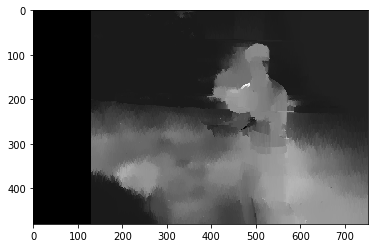

Object only in Right Camera


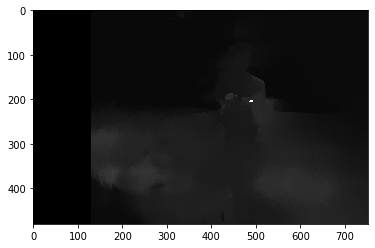

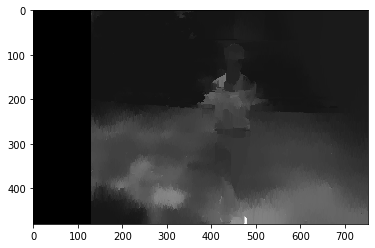

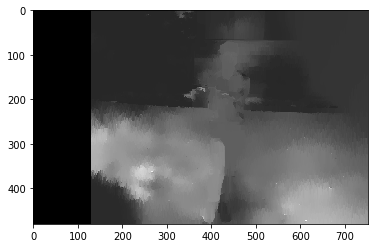

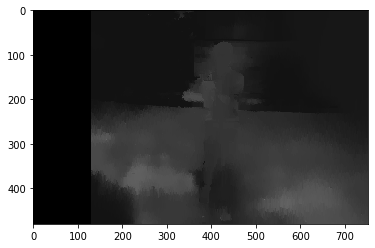

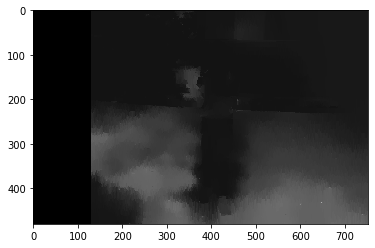

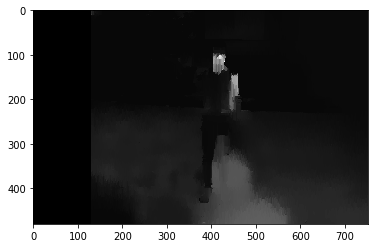

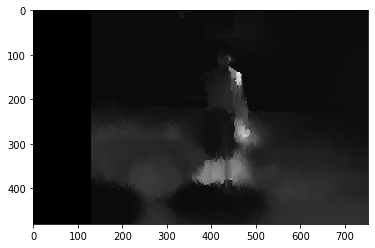

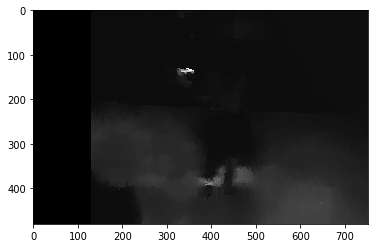

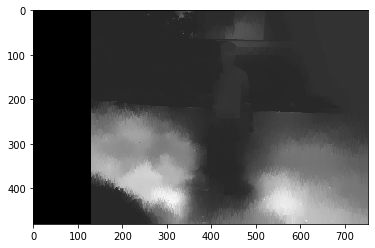

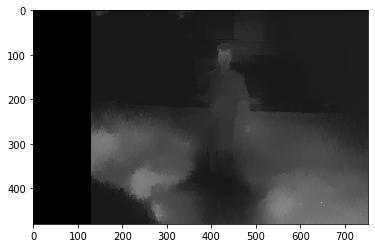

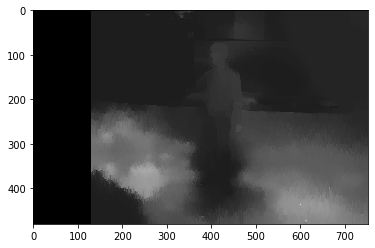

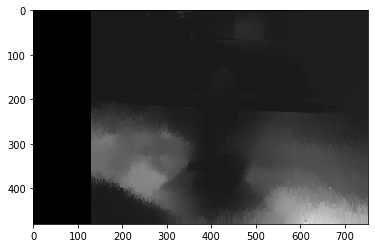

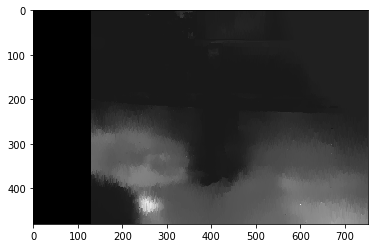

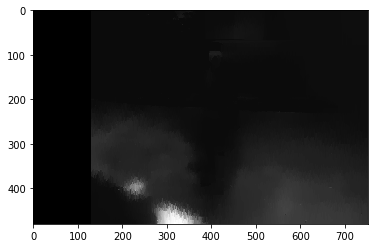

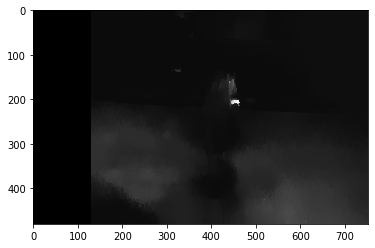

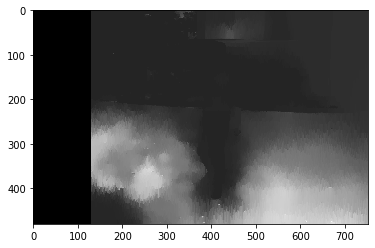

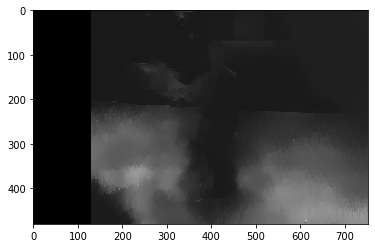

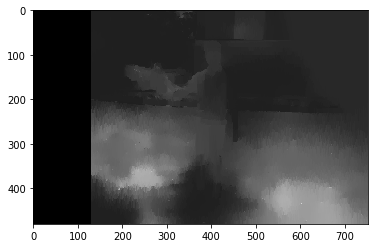

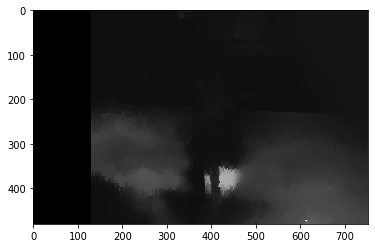

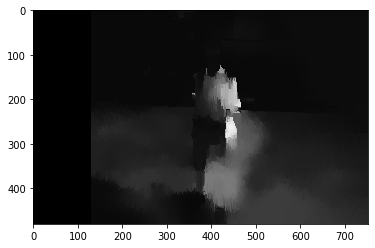

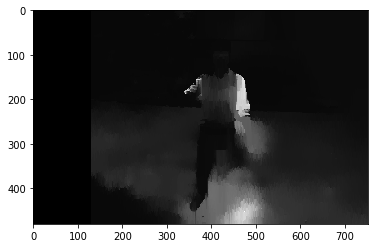

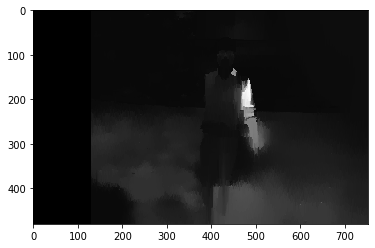

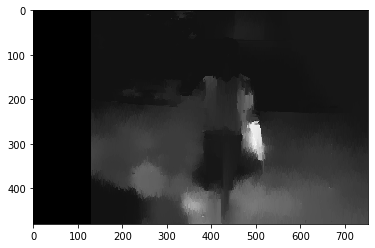

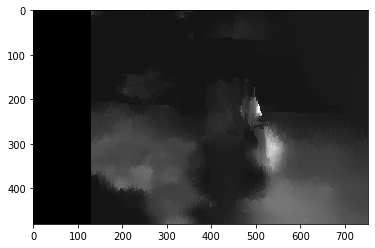

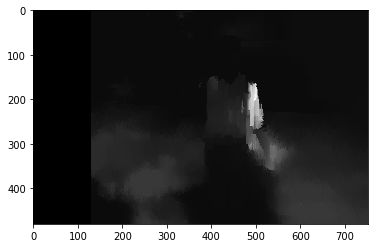

No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
Object only in Right Camera
No Object


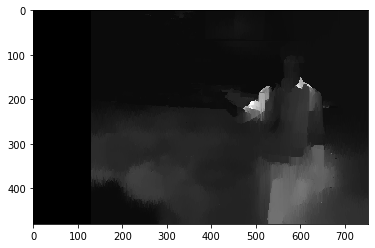

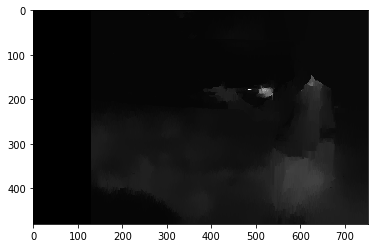

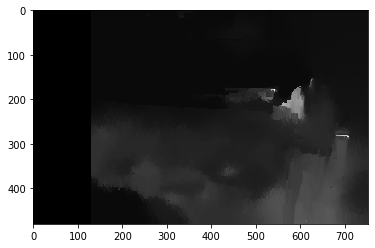

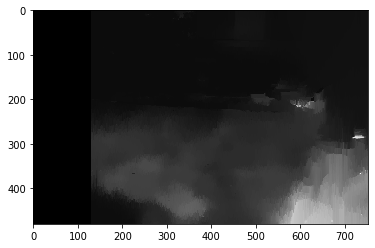

No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
Object only in Right Camera
No Object


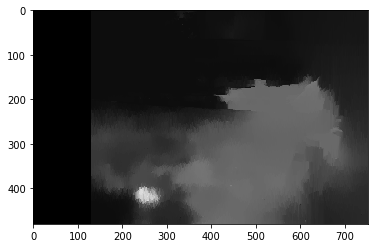

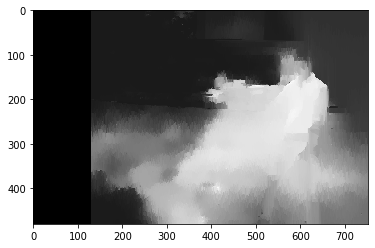

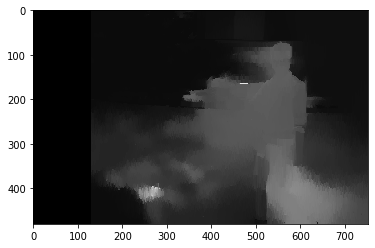

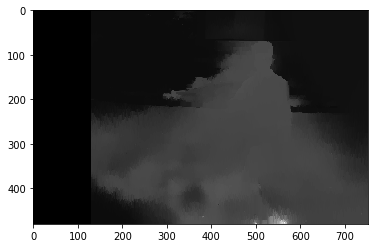

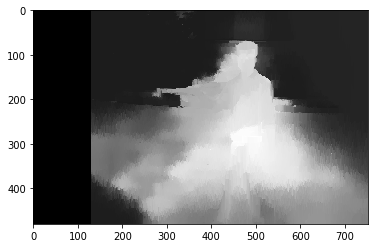

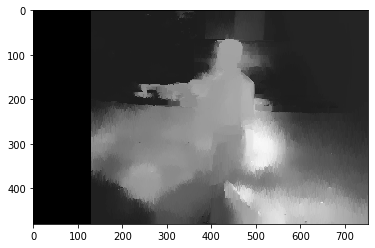

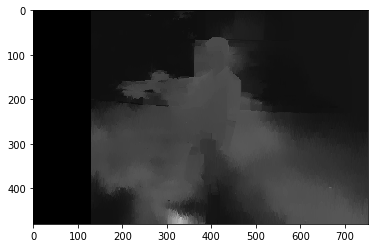

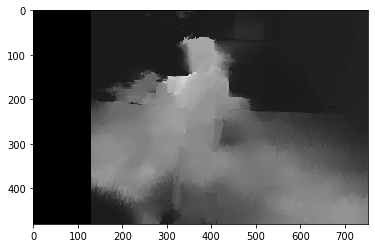

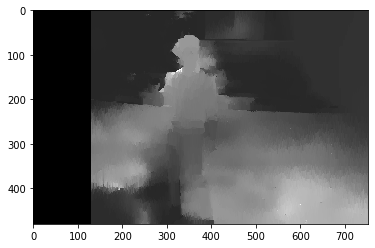

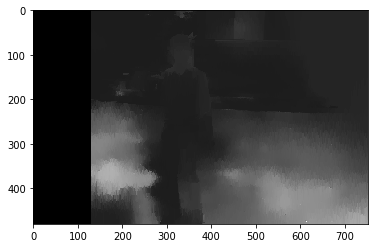

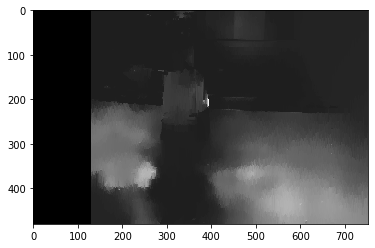

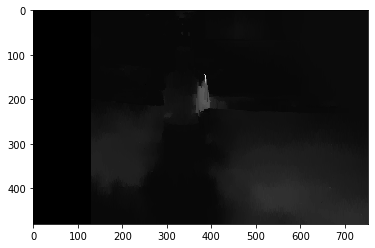

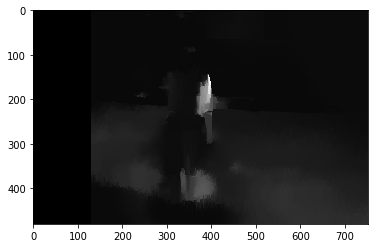

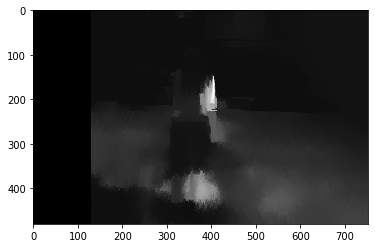

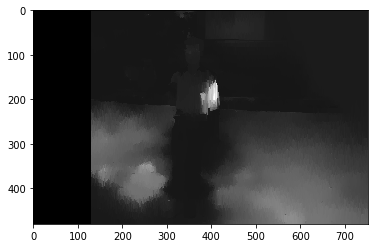

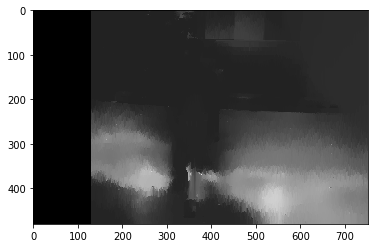

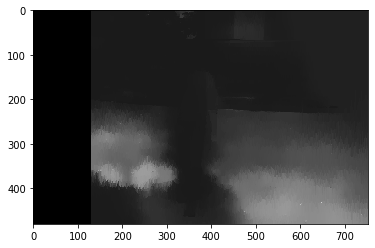

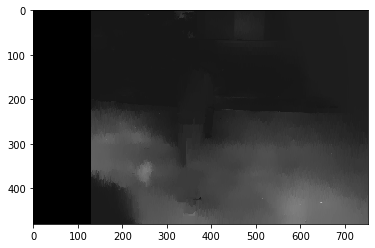

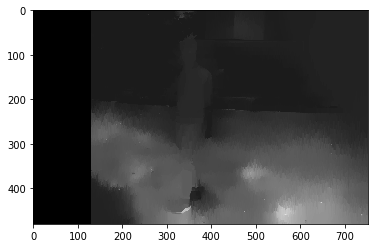

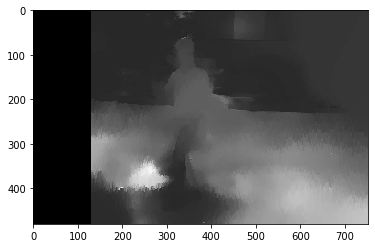

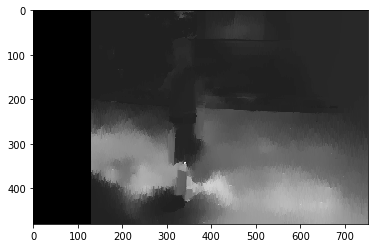

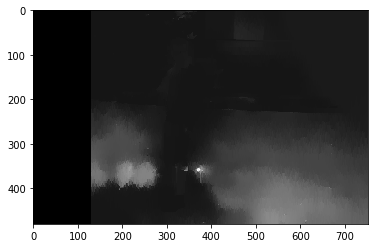

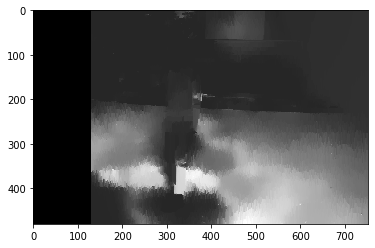

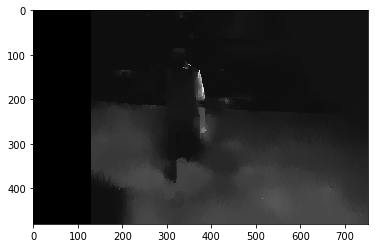

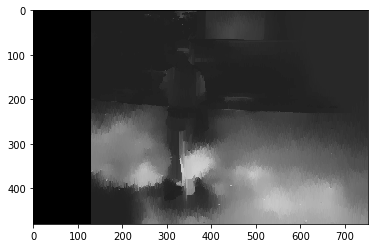

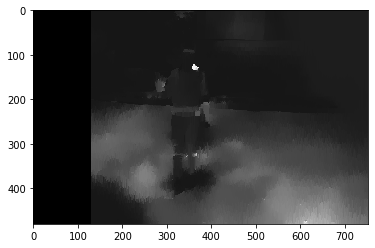

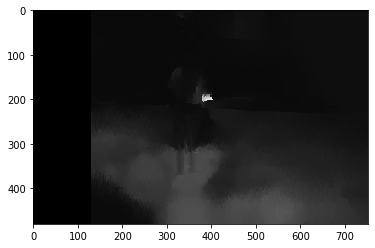

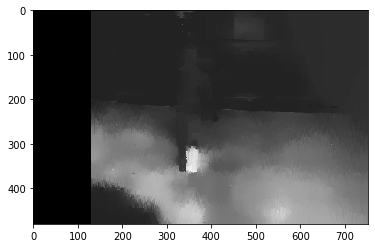

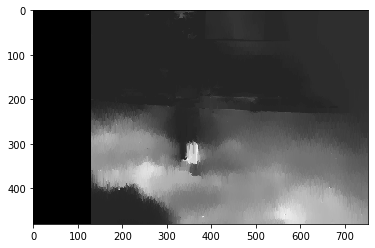

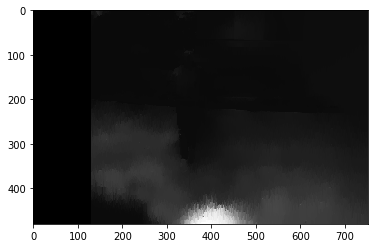

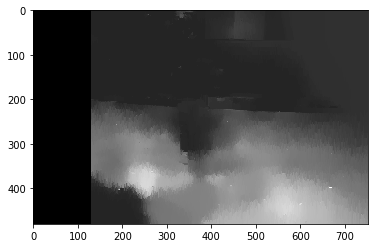

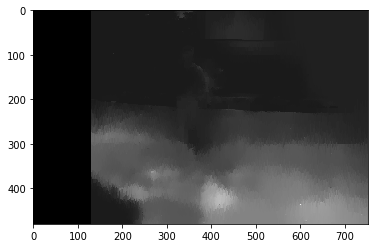

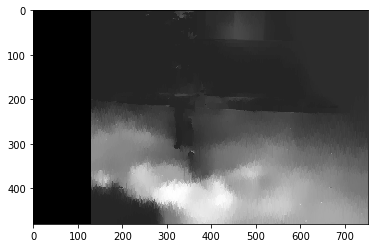

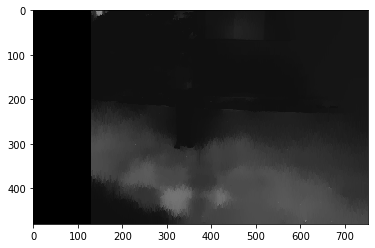

No Object
No Object
No Object
No Object
No Object
No Object
Object only in Right Camera


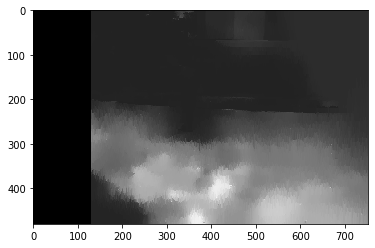

No Object


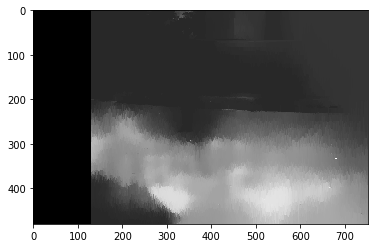

No Object
No Object
Object only in Right Camera


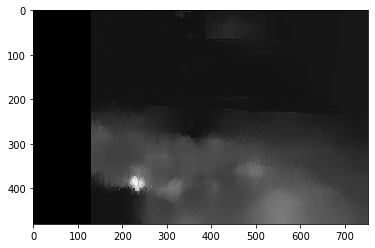

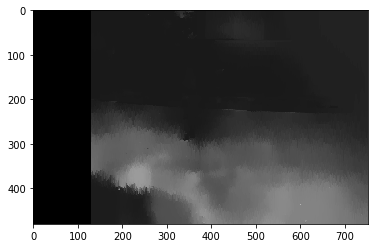

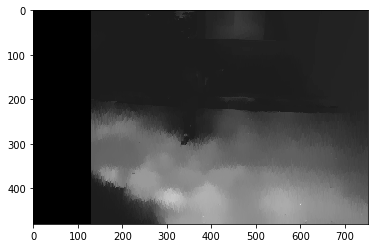

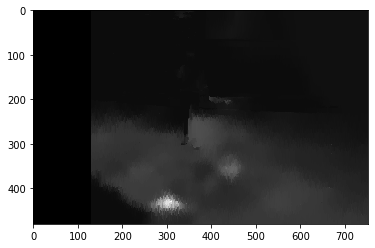

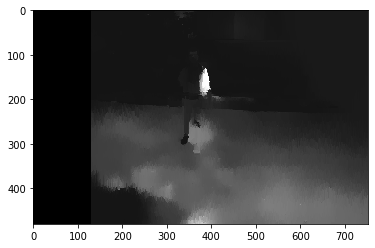

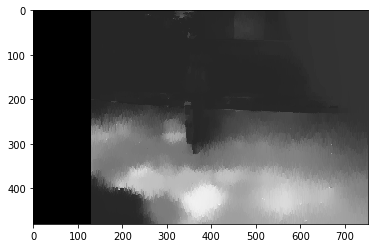

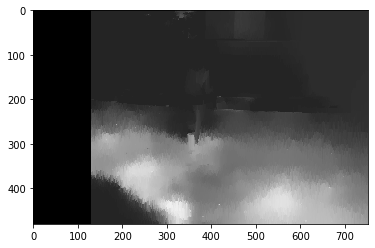

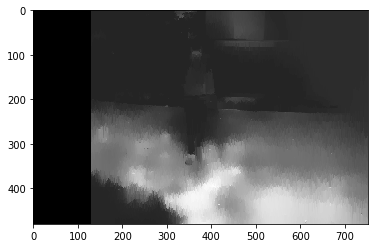

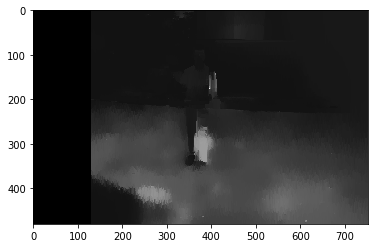

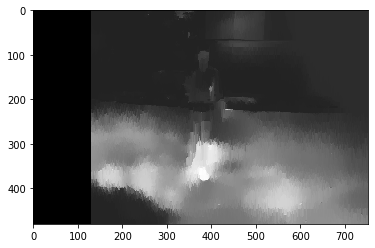

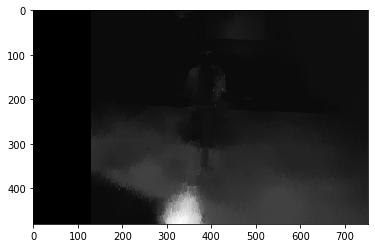

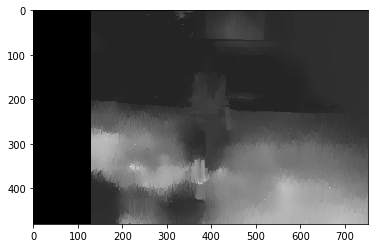

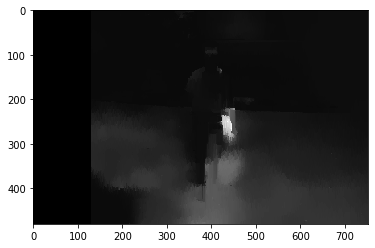

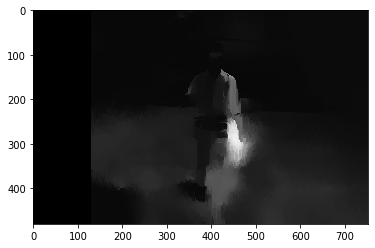

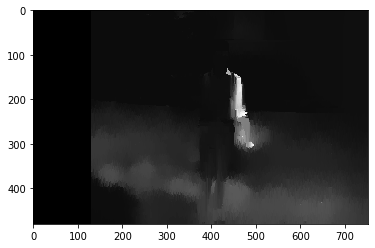

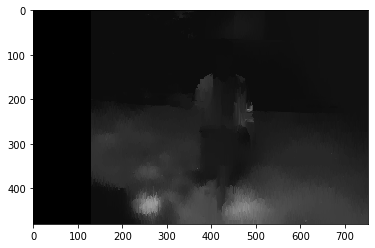

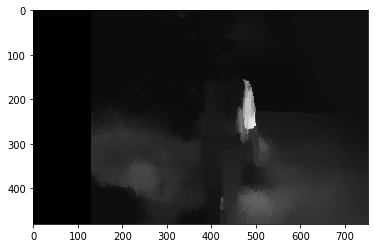

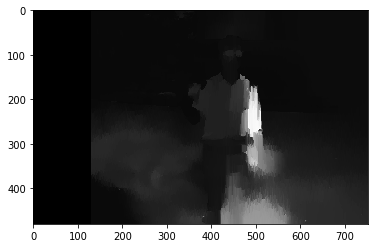

No Object


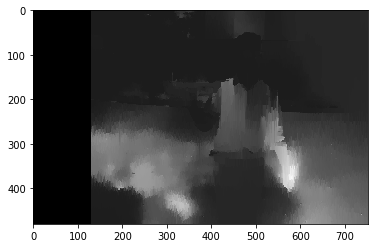

No Object
No Object
Object only in Right Camera
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
Object only in Right Camera
No Object
No Object
No Object
No Object
No Object
Object only in Right Camera


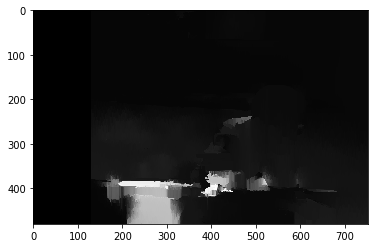

No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object


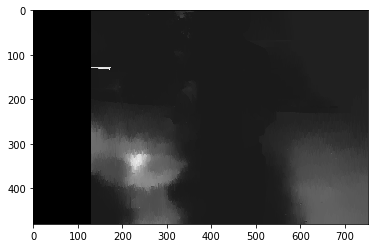

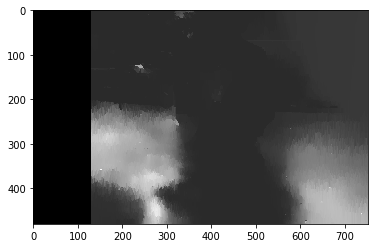

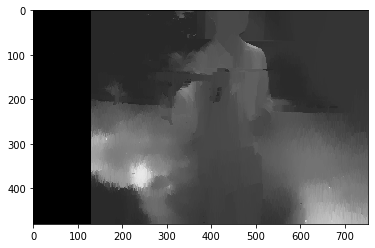

No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object


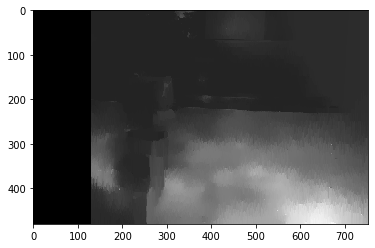

No Object


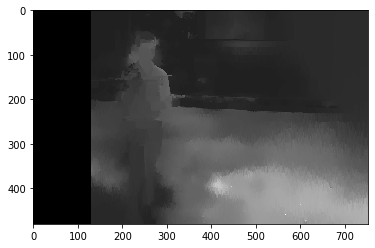

No Object
No Object


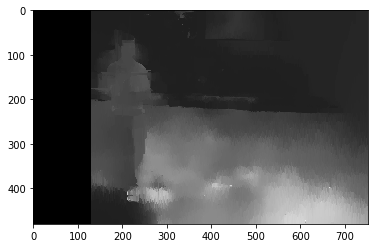

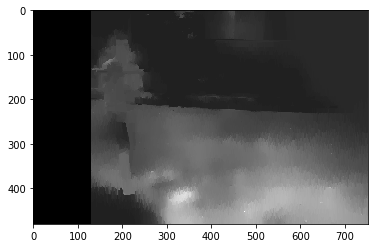

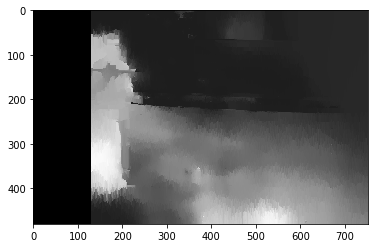

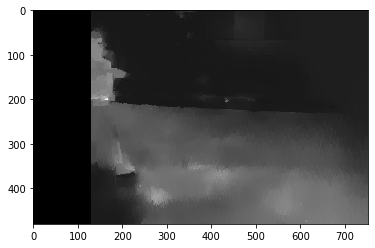

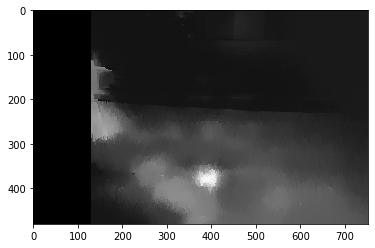

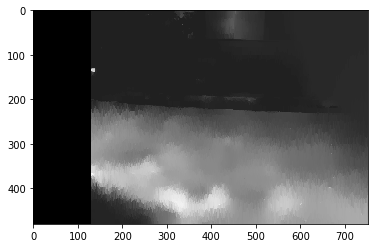

No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
Object only in Right Camera


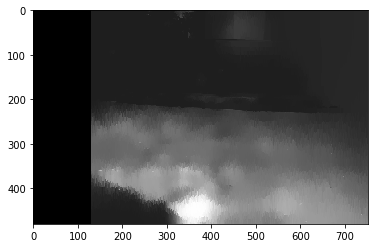

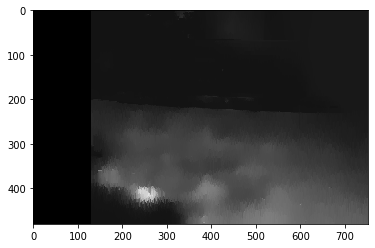

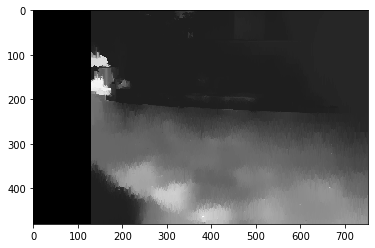

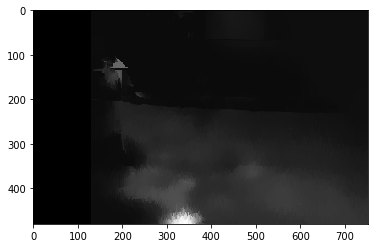

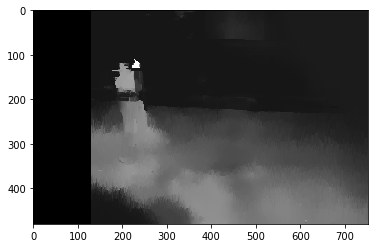

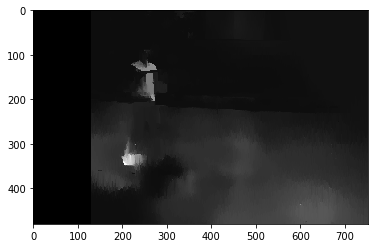

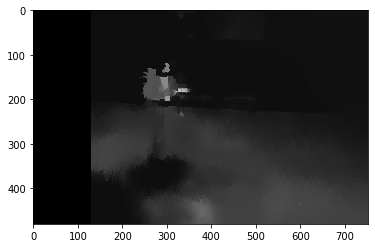

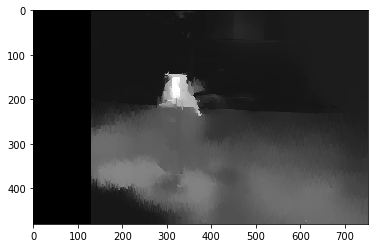

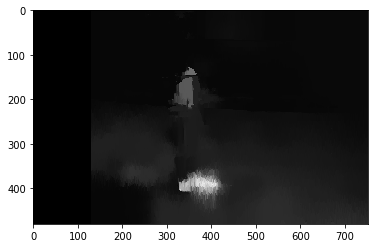

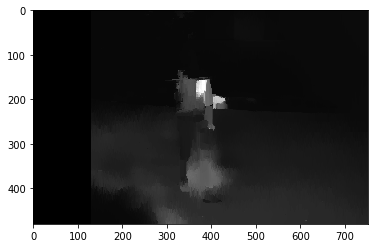

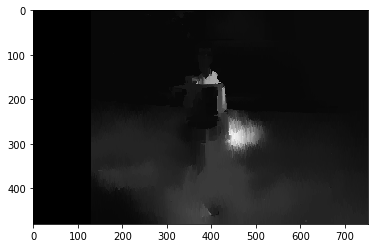

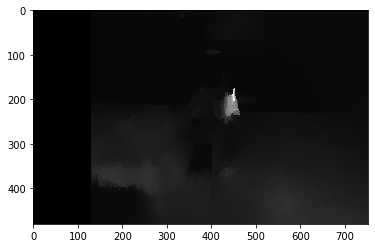

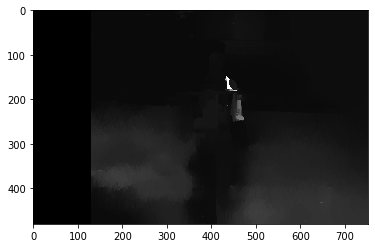

No Object


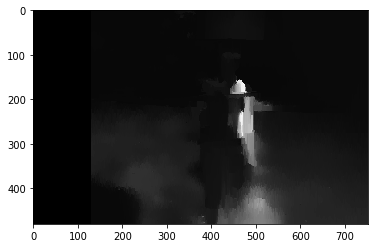

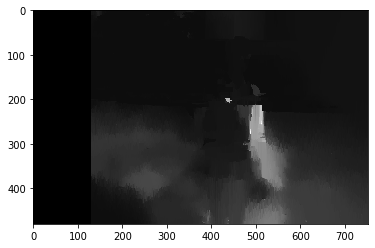

No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object


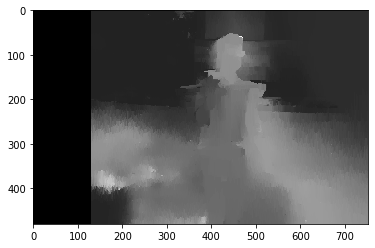

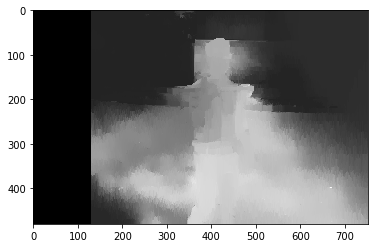

No Object
Object only in Right Camera
Object only in Right Camera


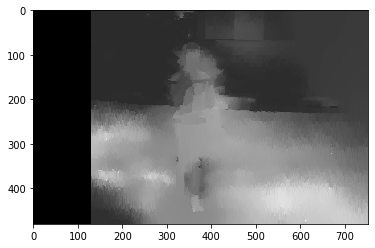

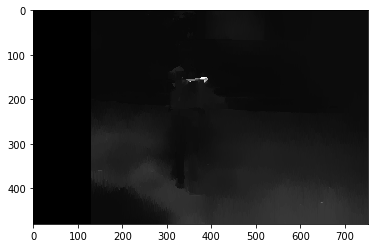

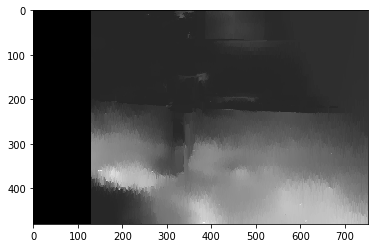

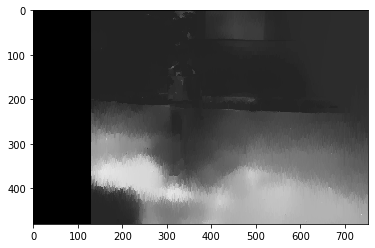

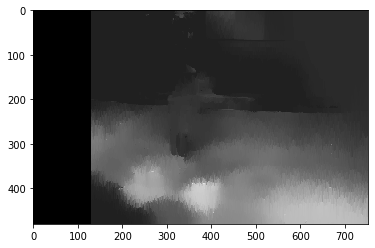

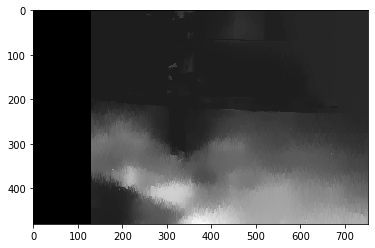

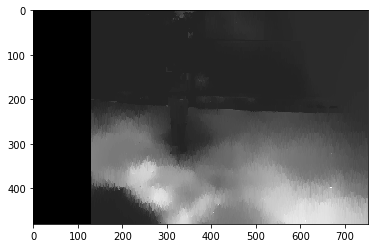

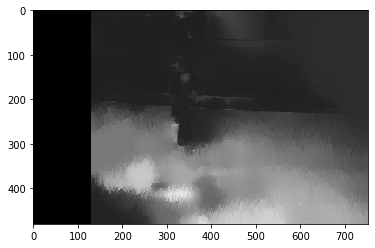

No Object
No Object
No Object
Object only in Right Camera


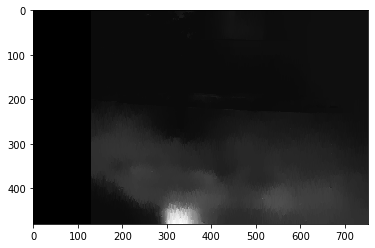

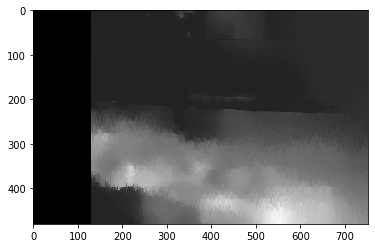

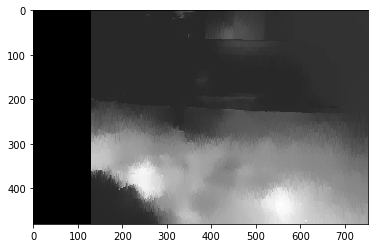

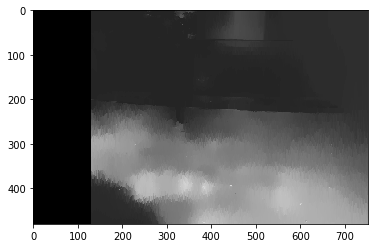

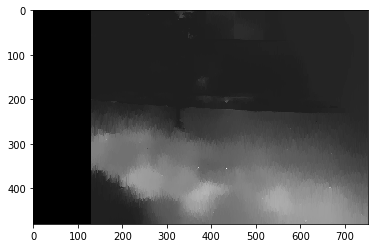

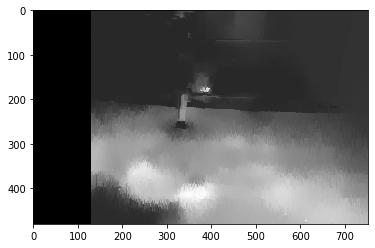

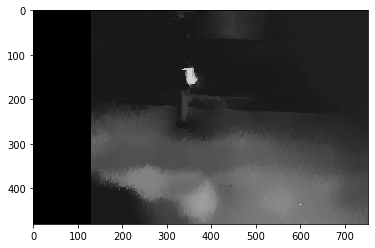

Object only in Right Camera


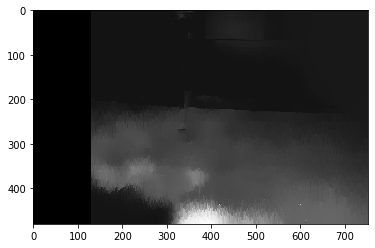

No Object
No Object
No Object


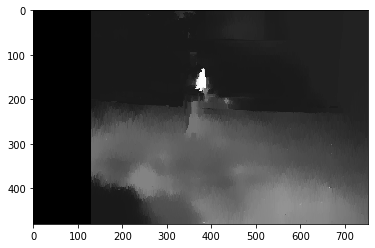

No Object
Object only in Right Camera


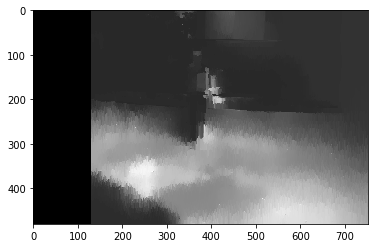

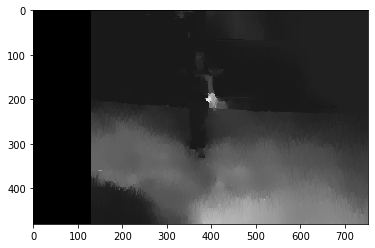

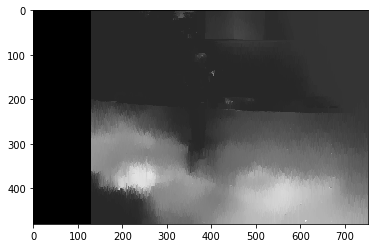

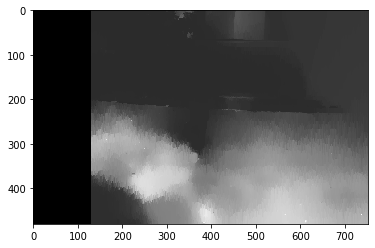

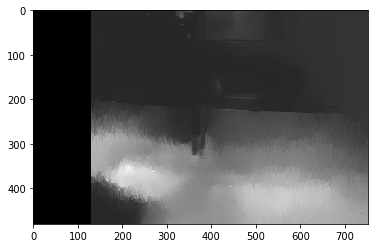

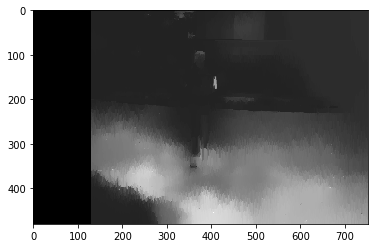

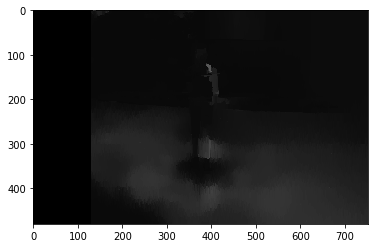

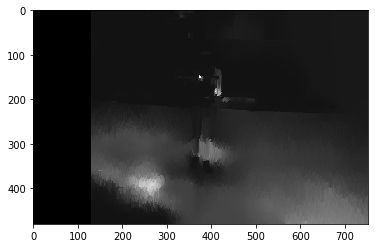

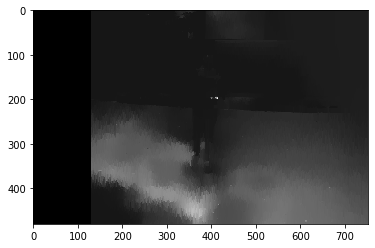

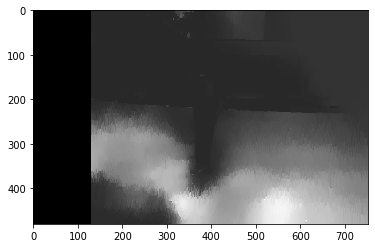

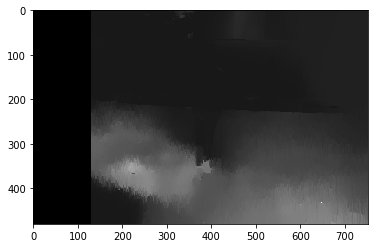

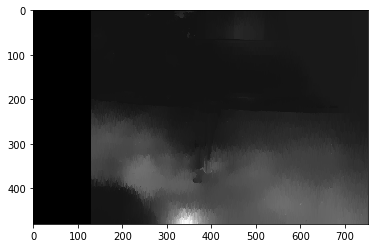

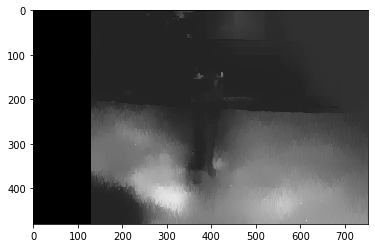

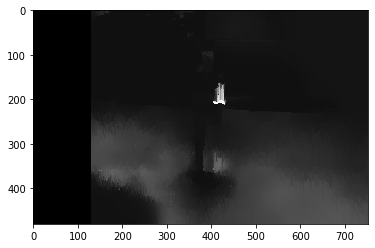

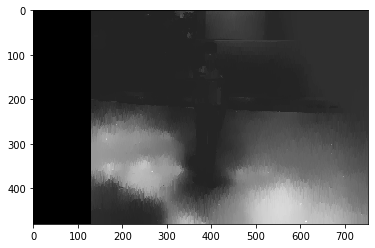

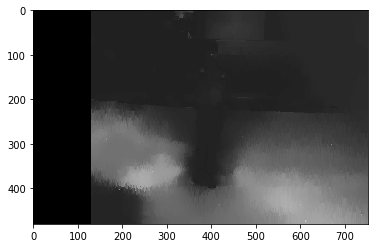

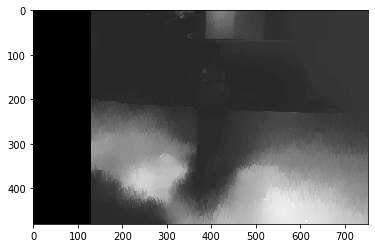

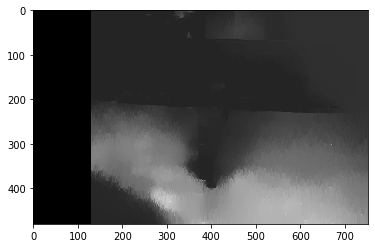

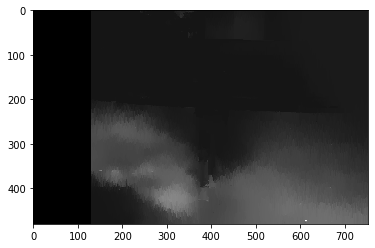

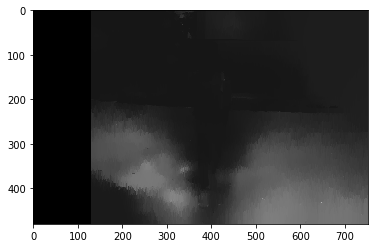

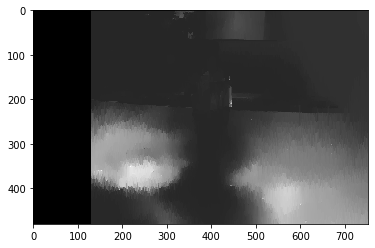

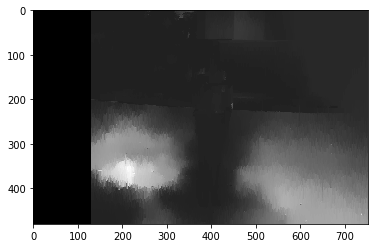

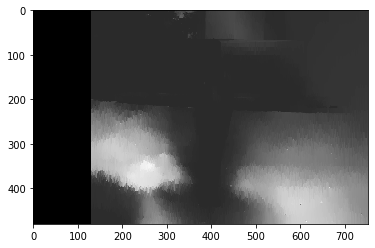

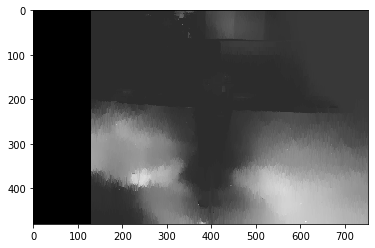

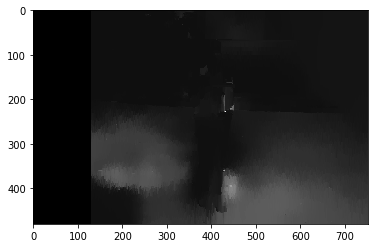

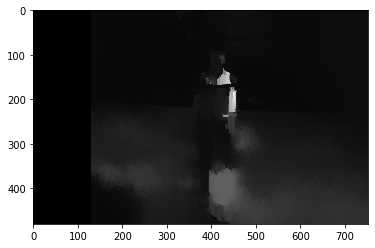

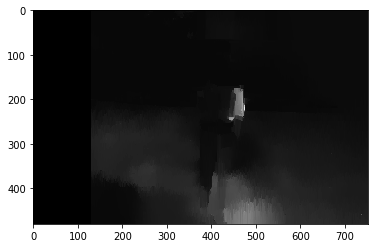

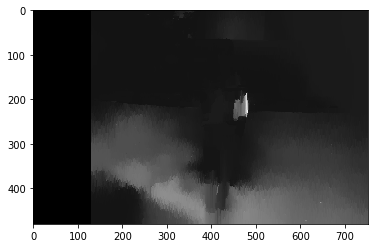

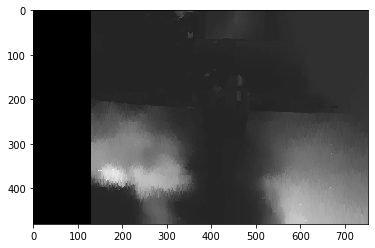

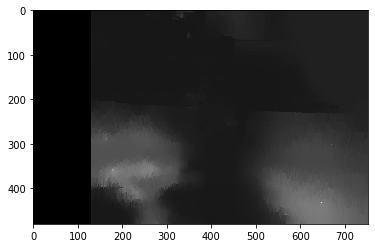

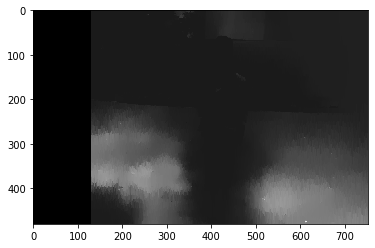

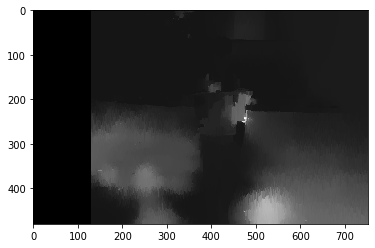

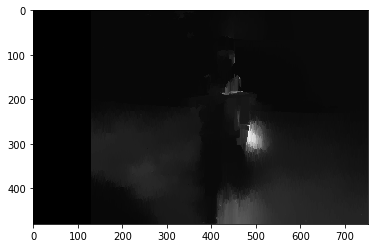

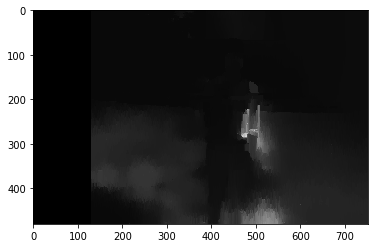

Object only in Right Camera
Object only in Right Camera


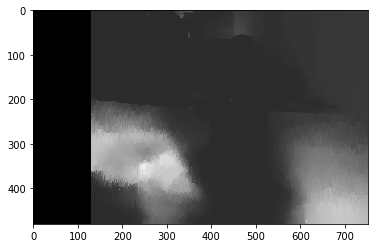

No Object


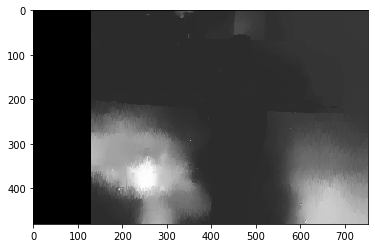

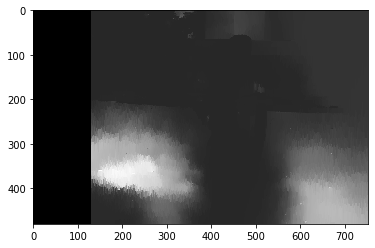

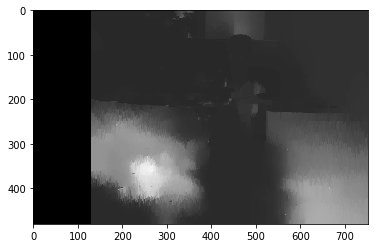

Object only in Right Camera
No Object
No Object
No Object
Object only in Right Camera
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object
No Object


In [11]:
start = time.time()
depth()
end = time.time()

In [ ]:
seconds = end-start
seconds

In [ ]:
fps = len(files)/seconds
fps